In [1]:
import numpy as np
import matplotlib.pyplot as plt
import STOM_higgs_tools
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import chi2

**Section 1** : Generating Data Points

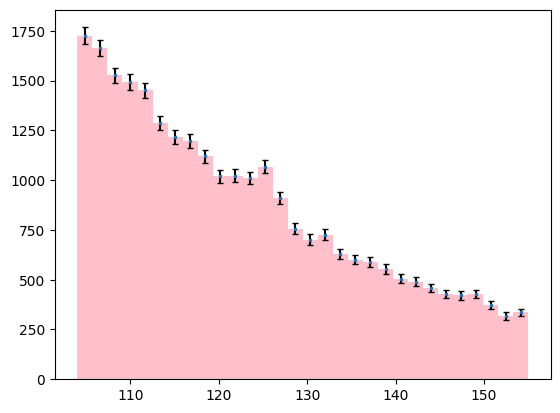

In [3]:
vals = STOM_higgs_tools.generate_data()
nbins=30
mass_range=[104,155]

bin_heights, bin_edges, patches = plt.hist(vals, range = mass_range, bins = nbins,color='pink')
bin_centre = bin_edges+0.5*(bin_edges[1]-bin_edges[0])
plt.errorbar(bin_centre[0:30],bin_heights,yerr=np.sqrt(bin_heights),capsize=2,fmt='x',ms=2,ecolor='black')
plt.show() 

**Section 2a**: Max likelihood method

**Section 2b**: $\chi^2$ Minimisation

Create a range of A and lambda values. For each value of A (`A[i]`), cycle through every lambda value (`lamb[j]`), and calculate the chi-squared values. Check if chi-squared value is less than previous chi-squared values, if so, set these values of A and lambda as the optimum. 

Note that we only use the range `[104,120]` because we need to ignore the higgs boson bump. 

In [4]:
L=50#number of A and lambda values to check
A=np.linspace(5e4,10e4,L) #range of predicted A values
lamb=np.linspace(25,35,L) #range of predicted lambda values
pbar = tqdm(range(L**2))
chi_grid=np.full((L,L),1e6)
mass_range_low=[104,120]
mass_range_high=[128,155]
nbins_low=9
nbins_high=16
for i in range(L):
    for j in range(L):
        chi_low=STOM_higgs_tools.get_B_chi(vals,mass_range_low,nbins_low,A[i],lamb[j])
        chi_high=STOM_higgs_tools.get_B_chi(vals,mass_range_high,nbins_high,A[i],lamb[j])
        chi=chi_low+chi_high
        if chi < np.min(chi_grid):
            chi_min_b=chi
            lamb_opt_b=lamb[j]
            A_opt_b=A[i]
        pbar.update(1)
        chi_grid[i,j]=chi
print(f'lambda = {lamb_opt_b}, A = {A_opt_b}, minimum chi={chi_min_b}')

  0%|          | 0/2500 [00:00<?, ?it/s]

lambda = 28.06122448979592, A = 77551.02040816327, minimum chi=2.4952927131476175


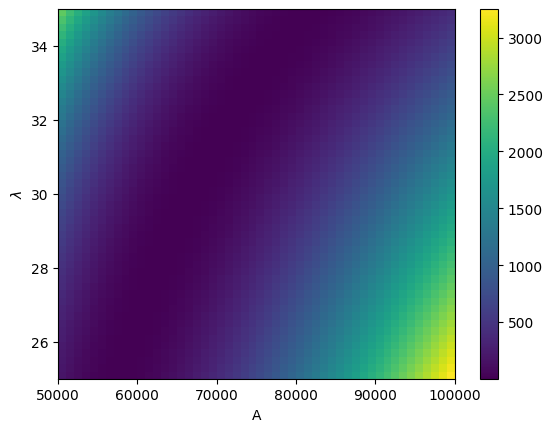

In [5]:
plt.imshow(chi_grid, cmap='viridis', aspect='auto', extent=[np.min(A), np.max(A), np.min(lamb), np.max(lamb)])
plt.colorbar()
plt.xlabel('A')
plt.ylabel('$\lambda$')
plt.show()

The above plot establishes that there isn't some *minimum point*: some pair of A and $\lambda$ that gives the best possible $\chi^2$ value. There is instead a 'valley' of minimum points. You can in-fact pick any fixed value of A, and vary lambda to find the perfect value. The code below chooses a fixed value of A, and iterates through values of lambda. 

In [6]:
L=100#number of lambda values to check
A=60000
lamb=np.linspace(25,35,L) #range of predicted lambda values
pbar = tqdm(range(L))
chi_list=np.full((1,L),1e6)
for j in range(L):
    chi_low=STOM_higgs_tools.get_B_chi(vals,mass_range_low,nbins_low,A,lamb[j])
    chi_high=STOM_higgs_tools.get_B_chi(vals,mass_range_high,nbins_high,A,lamb[j])
    chi=chi_low+chi_high
    if chi < np.min(chi_list):
        chi_min_b=chi
        lamb_opt_b=lamb[j]
    pbar.update(1)
    chi_list[0,j]=chi
A_opt_b=A
print(f'lambda = {lamb_opt_b}, A = {A_opt_b}, minimum chi={chi_min_b}')

  0%|          | 0/100 [00:00<?, ?it/s]

lambda = 29.848484848484848, A = 60000, minimum chi=4.427708848858823


**Section 3:** Goodness of fit

Find fit using optimised parameters:

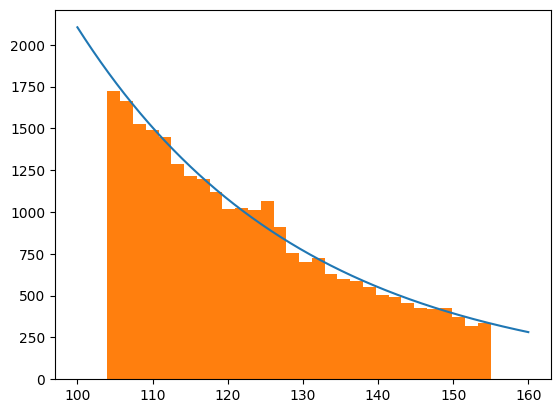

In [7]:
x=np.linspace(100,160,10000)
y=STOM_higgs_tools.get_B_expectation(x,A_opt_b,lamb_opt_b)
plt.plot(x,y)
bin_heights, bin_edges, patches = plt.hist(vals, range = mass_range, bins = nbins)
plt.show() 

**Section 4a**: 

Chi-squared value for the *entire* range. Should be less than degrees of freedom `nbins-2`: i.e. 28

**Note** Remember to multiply outputted value by 28: because the function automatically divides by 28 :( :( :( 

Also find p-value

In [8]:
def calculate_p_value(chi_squared,sample_size,parameter_number):
    degrees_of_freedom = sample_size - parameter_number
    p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)
    return p_value

chi_total = STOM_higgs_tools.get_B_chi(vals,[104,155],30,A_opt_b,lamb_opt_b)*28
print(chi_total)
sample_size=30
parameter_number=2

p_value = calculate_p_value(chi_total,sample_size,parameter_number)
print(p_value)

79.4680368157428
8.008712678586605e-07


**Section 4b**: Finding mean $\chi^2$ value over many signal generations (background only). Use previous optimised values.

  0%|          | 0/100 [00:00<?, ?it/s]

mean_chi= 2.819171582284163+/- 0.8166296146227925


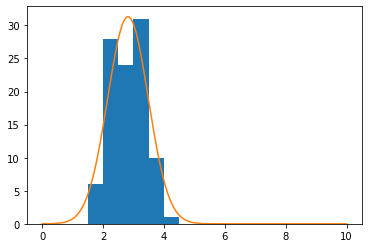

In [139]:
A_opt = A_opt_b
lamb_opt = lamb_opt_b

simulations = 100

chi_list = []

pbar = tqdm(range(simulations))
for i in range(simulations):
    vals=STOM_higgs_tools.generate_data()
    nbins=30
    mass_range =[104,155]
    chi=STOM_higgs_tools.get_B_chi(vals,mass_range,nbins,A_opt,lamb_opt)
    chi_list=np.append(chi_list,chi)
    pbar.update(1)

chi_range=[0,10]
chi_bins = 20
bin_heights, bin_edges, patches = plt.hist(chi_list, range = [0,10], bins = chi_bins)
half_bin_width = 0.5*(bin_edges[1] - bin_edges[0])

#fitting a gaussian to the histogram to find the mean value (this is the value of chi we take)
fit,cov = curve_fit(STOM_higgs_tools.signal_gaus, bin_edges[0:20]+half_bin_width, bin_heights)
x=np.linspace(bin_edges[0],bin_edges[-1:],1000)
y=STOM_higgs_tools.signal_gaus(x,*fit)
plt.plot(x,y)

mean_chi = fit[0]
err_chi= np.sqrt(fit[1])
print(f'mean_chi= {mean_chi}+/- {err_chi}')


**Section 4c:** Finding mean $\chi^2$ value with various signal amplitudes

**Section 5a**: Signal Estimation using background parameterisation

Overlaying the signal

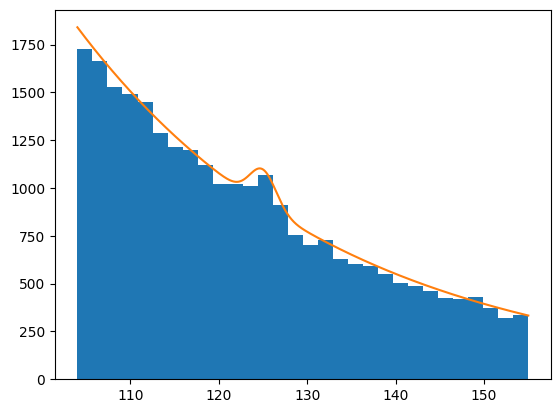

In [9]:
A_opt= A_opt_b
lamb_opt= lamb_opt_b
mass_range=[104,155]

bin_heights, bin_edges, patches = plt.hist(vals, range = mass_range, bins = 30)

signal_mean = 125 
signal_sig = 1.5
signal_amp = 700

x=np.linspace(104,155,10000)
y=STOM_higgs_tools.get_SB_expectation(x,A_opt,lamb_opt,signal_mean,signal_sig,signal_amp)
plt.plot(x,y)
plt.show() 

Finding $\chi^2$

In [10]:
half_bin_width = 0.5*(bin_edges[1] - bin_edges[0])
#recalculate ys_expected, but using half-bin widths
ys_expected = STOM_higgs_tools.get_SB_expectation(bin_edges+half_bin_width, A_opt, lamb_opt, signal_mean, signal_sig, signal_amp)
chi = 0

for i in range( len(bin_heights) ):
    chi_nominator = (bin_heights[i] - ys_expected[i])**2
    chi_denominator = ys_expected[i]
    chi += chi_nominator / chi_denominator

print('chi value is:',chi) #don't need to multiply because the function accounts for this

# Find p-value using previously-defined function
chi_squared_value = chi
sample_size = 30 
parameter_number = 5

p_value = calculate_p_value(chi_squared_value, sample_size, parameter_number)
print("p-value:", p_value)
print('acceptance range', p_value*100,'%')

chi value is: 49.14515217342007
p-value: 0.002712460285785645
acceptance range 0.2712460285785645 %


**Section 5b:** Unknown Mass